# Classification of short political articles collected from several news/opinions websites 
# ** By Y. Kostrov
***

***
# Overview
 In this project, I create a model that will classify political articles into three categories consisting
  "left", "right", and "center".

 During the analysis:
 1. I perform exploratory data analysis.
 2. I prepare the data for training.
 3. I will split the data into training and testing sets.
 4. I explore three different embeddings for text: Counting(Count Vectorizing), Term Frequency–Inverse Document Frequency (TFIDF), and Doc2Vec.
 5. I build a Naive Base model, Logistic Regression, Random Forest, and Deep Learing models.
 6. I compare the results of the models to choose the better model based on the metric described below and retrain it on the whole data set.


# Business Problem
This project is centered around understanding the political view of the short article that we can find on the internet. It is, often, very hard to decide which political inclination the article has. The reader can take the text and use the model that comes out of this project to confirm the understanding of the political notion that the user has after reading with the prediction of the model.

# Metrics for Assessment
1. The primary metric for this project will be accuracy. Accuracy is the number of correct predictions divided by total number of predictions. Since we have a pretty close number of articles in three different classes, accuracy should serve well as a primary metric. I will also look at the confusion matrix to keep an eye on the False Negatives and False Positives counts.
2. Based on part 1., I use precision and recall as two additional metrics. Recall is defined as a number of true positives divided by the number of total atual positives. Precision is defined as a number of true positives divided by the total number predicted as positives.

# Data Description.
The data for this project was collected by me from the following websites: www.freebeacon.com, www.americanthinker.com, www.huffpost.com, www.slate.com, news.gallup.com, www.cbsnews.com. I put the articles into three category based on the political view of the hosting website. The categories are "left", "center", and "right". The data file has only two columns: "article" and "label".


# Import the packages

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from collections import defaultdict, Counter
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import re
import gensim
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SpatialDropout1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.preprocessing import LabelBinarizer

In [180]:
# read the data
df = pd.read_csv("../data/test_2.csv")
df.head()

,article,label
0,Mental health professionals are no substitute ...,right
1,Merrick Garland's focus on school board meetin...,right
2,The president has yet to clarify what victory ...,right
3,"To hear President Joe Biden tell it, the Ameri...",right
4,The mainstream media's honeymoon with Presiden...,right


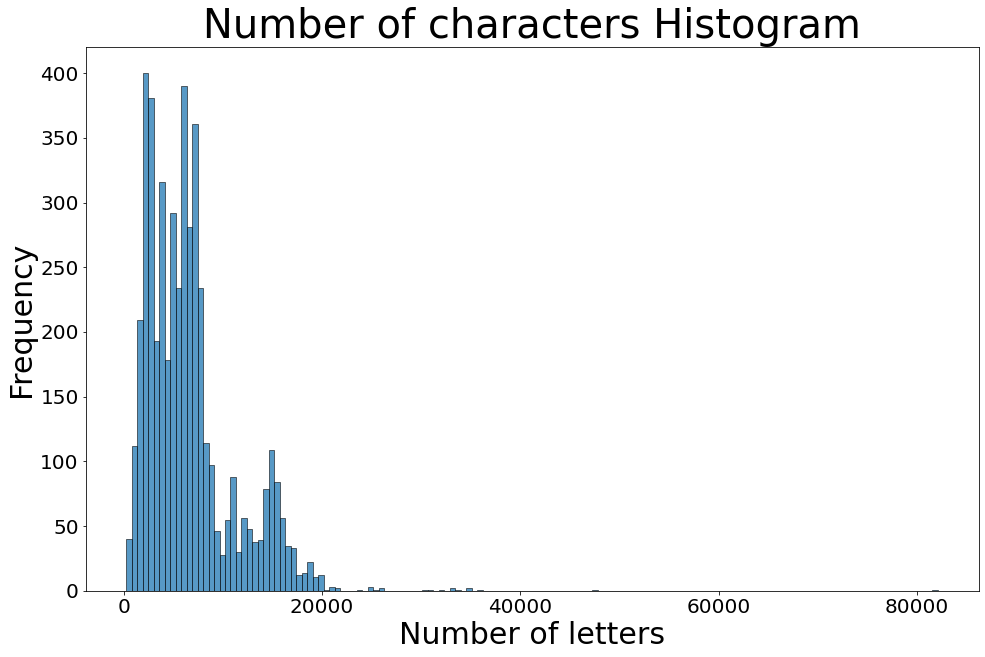

<Figure size 432x288 with 0 Axes>

In [42]:
# Plot number of characters present in each sentence
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.len())
plt.title("Number of characters Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Number of letters', fontsize=30)
plt.xticks(fontsize=20)
plt.show()
plt.savefig("../img/lenthCharsHist.png")

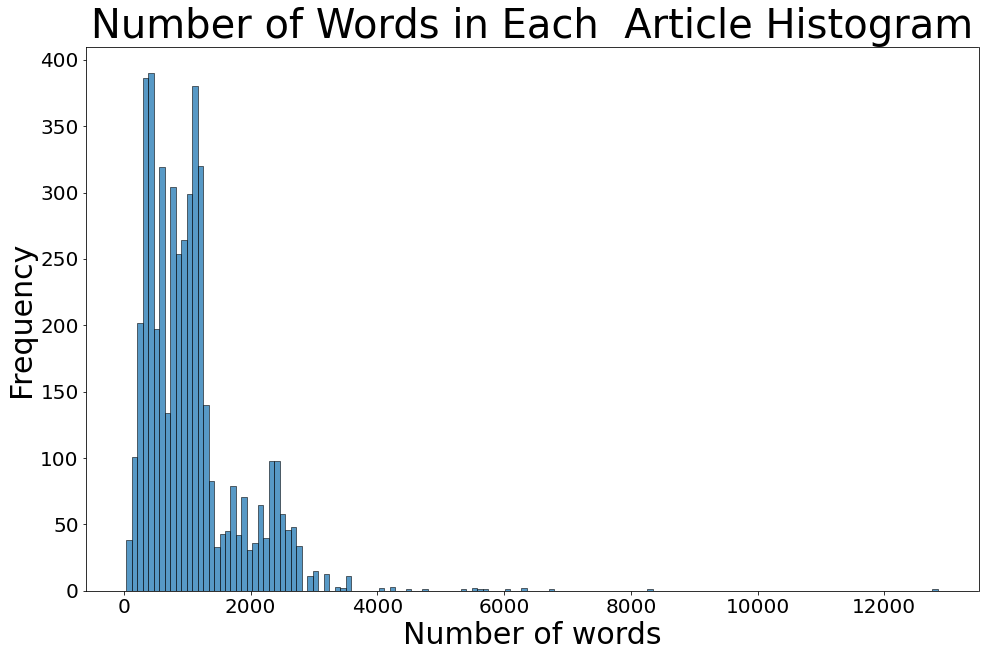

<Figure size 432x288 with 0 Axes>

In [43]:
# plot number of words appearing in each article
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.split().map(lambda x: len(x)))
plt.title("Number of Words in Each  Article Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Number of words', fontsize=30)
plt.xticks(fontsize=20)
plt.show()
plt.savefig("../img/wordsCharsHist.png")

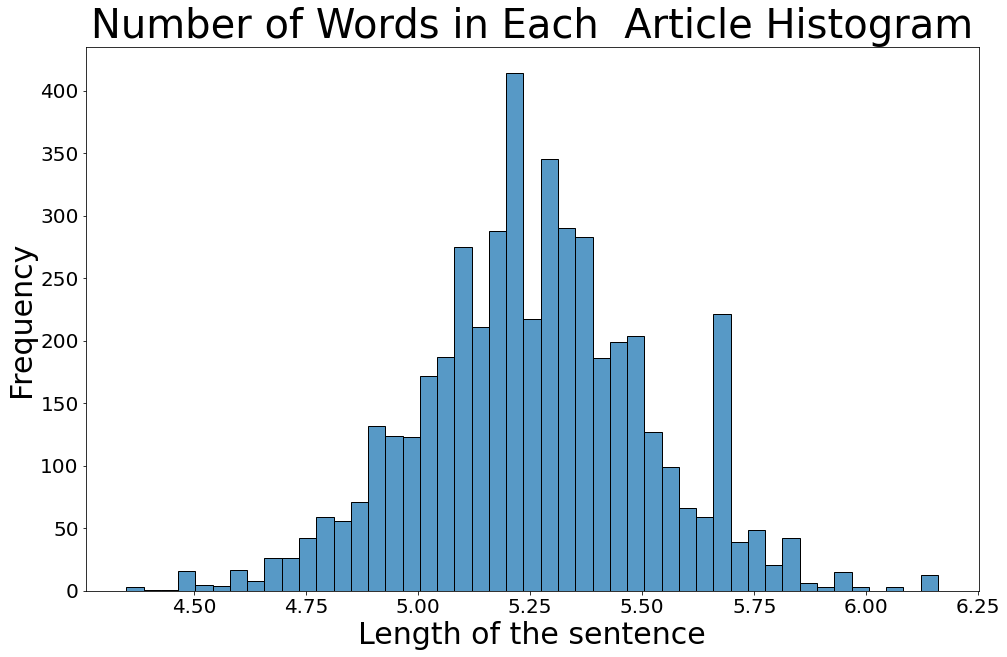

<Figure size 432x288 with 0 Axes>

In [44]:
# plot average word length in each sentence.
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)))
plt.title("Number of Words in Each  Article Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Length of the sentence', fontsize=30)
plt.xticks(fontsize=20)
plt.show()
plt.savefig("../img/lenthSentenseHist.png")

In [45]:
# collect stopwords that are needed later
stop = set(stopwords.words('english'))

In [46]:
# build the corpus
corpus = [] 
article = df.article.str.split()
article = article.values.tolist()
corpus = [word for i in article for word in i]

In [47]:
# set up a dictionary
dictionary = defaultdict(int)

In [48]:
# fill in the dictionary
for word in corpus:
    if word in stop:
        dictionary[word] +=1

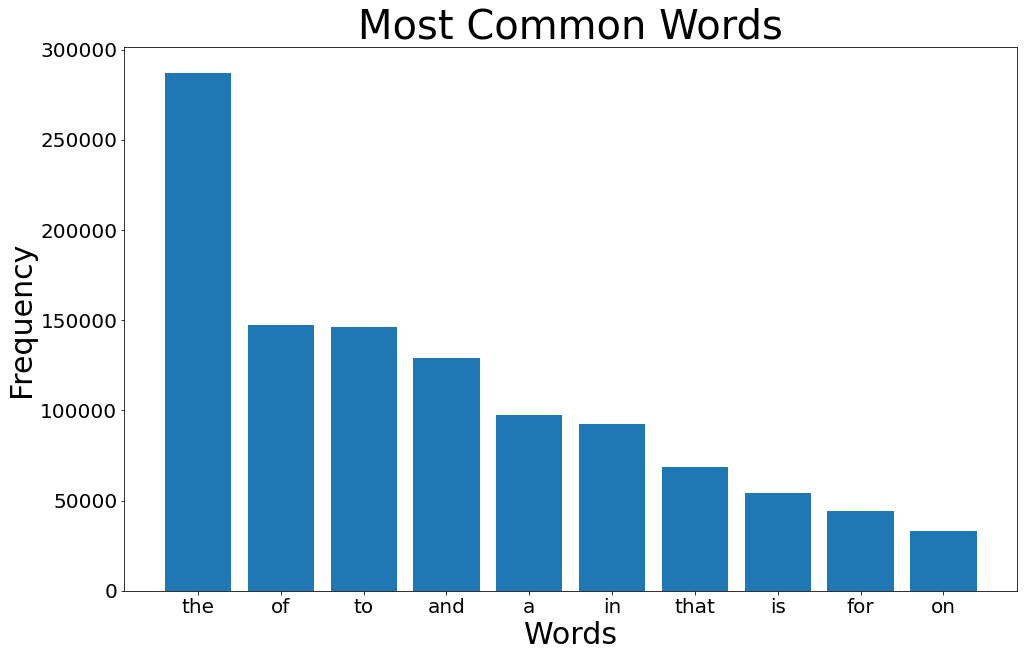

<Figure size 432x288 with 0 Axes>

In [49]:
# check the most common words in dictionary
top=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)[:10] 
x,y=zip(*top)
plt.figure(figsize=(16,10))
plt.bar(x,y)
plt.title("Most Common Words", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Words', fontsize=30)
plt.xticks(fontsize=20)
plt.show()
plt.savefig("../img/mostCommonWords.png")

In [50]:
"""
we know which stopwords occur frequently in our text,
let’s inspect which words other than these stopwords
occur frequently.
"""

'\nwe know which stopwords occur frequently in our text,\nlet’s inspect which words other than these stopwords\noccur frequently.\n'

In [51]:
# Create place holders for common words - x and counts of common words - y
x, y = [], []

In [127]:
# take all most common words then skip the ones in the stopwords
counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:60]:
    word = word.lower()
    if (word not in stop):
        x.append(word)
        y.append(count)

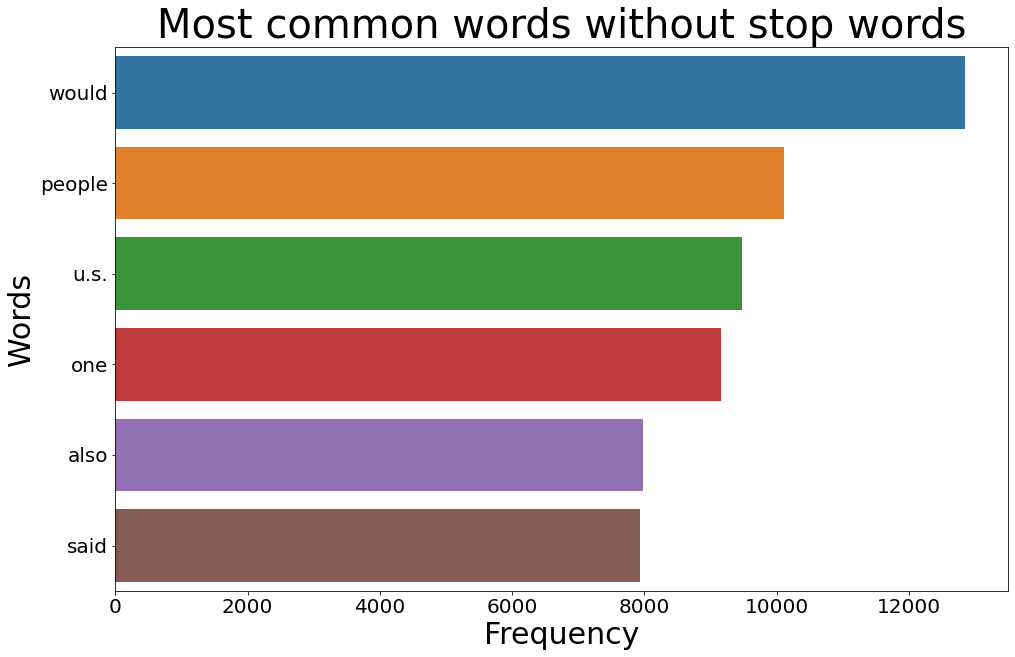

<Figure size 432x288 with 0 Axes>

In [128]:

plt.figure(figsize=(16,10))
sns.barplot(x=y,y=x)
plt.title("Most common words without stop words", fontsize=40)
plt.ylabel('Words', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=30)
plt.xticks(fontsize=20)
plt.show()
plt.savefig("../img/mostCommonWordsNoStopWords.png")

In [54]:
# size of the corpus
len(corpus)


4999681

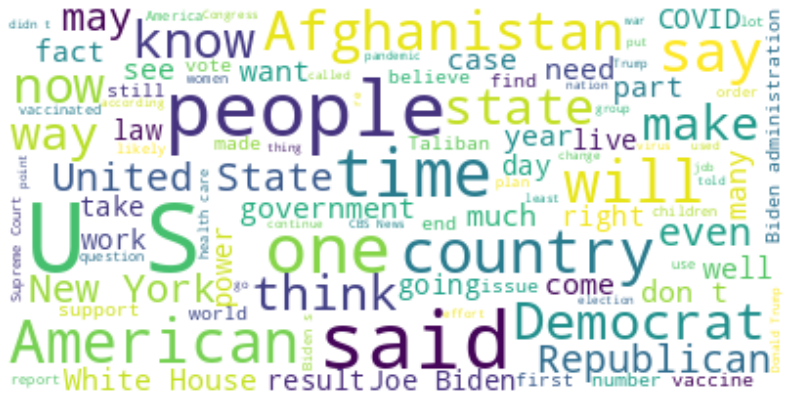

In [129]:

text = " ".join(corpus)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
wordcloud.to_file("../img/cloud.png")
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [136]:
# building word cloud
def buildWordCloud(df, fileName):
    locCorpus = []
    article = df.article.str.split()
    article = article.values.tolist()
    locCorpus = [word for i in article for word in i]
    text = " ".join(corpus)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    wordcloud.to_file("../img/cloud_" + fileName + ".png")
    plt.figure(figsize=(14,8))
    plt.title(label.capitalize(), fontsize=50)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


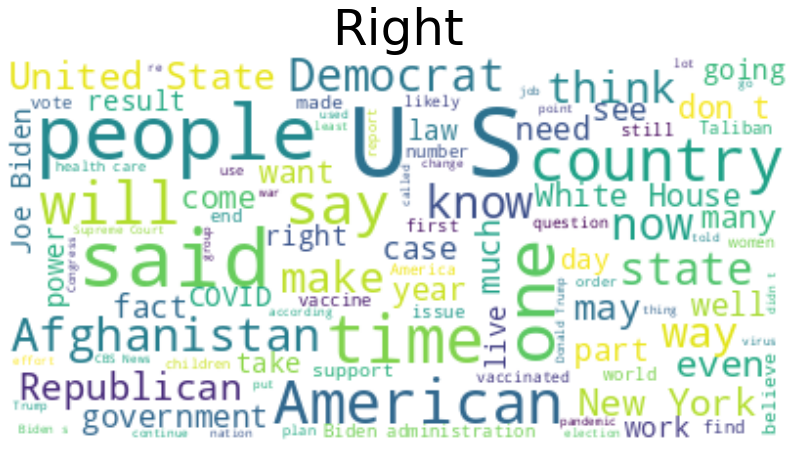

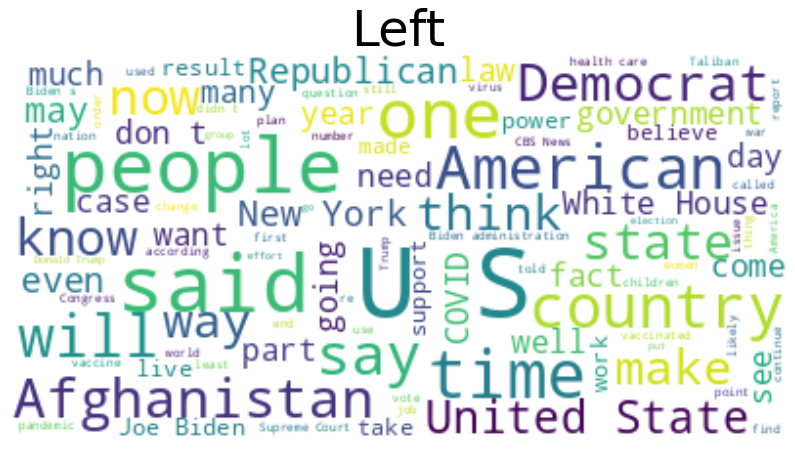

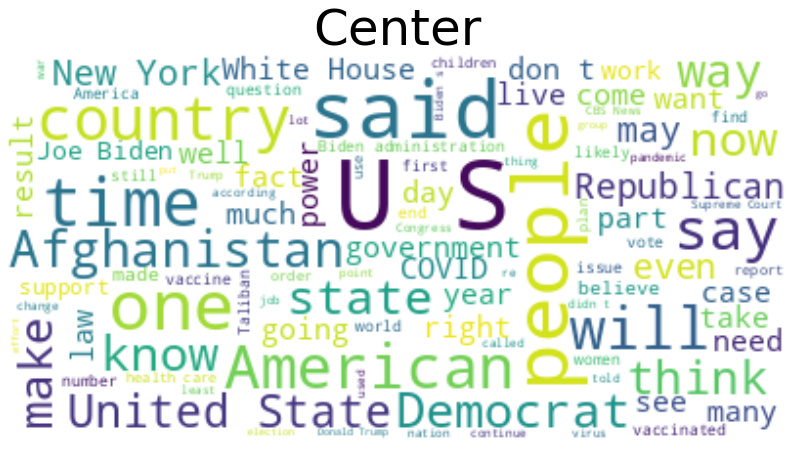

In [137]:
for label in ['right','left','center']:
    curr_df =df[df.label == label]
    buildWordCloud(curr_df, label)

In [56]:
# check the distribution of labels by classes
x_label = df.label.value_counts()
y_label = x_label.sort_index()

/Users/yevgeniykostrov/.local/share/virtualenvs/library-UZqeyXYS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


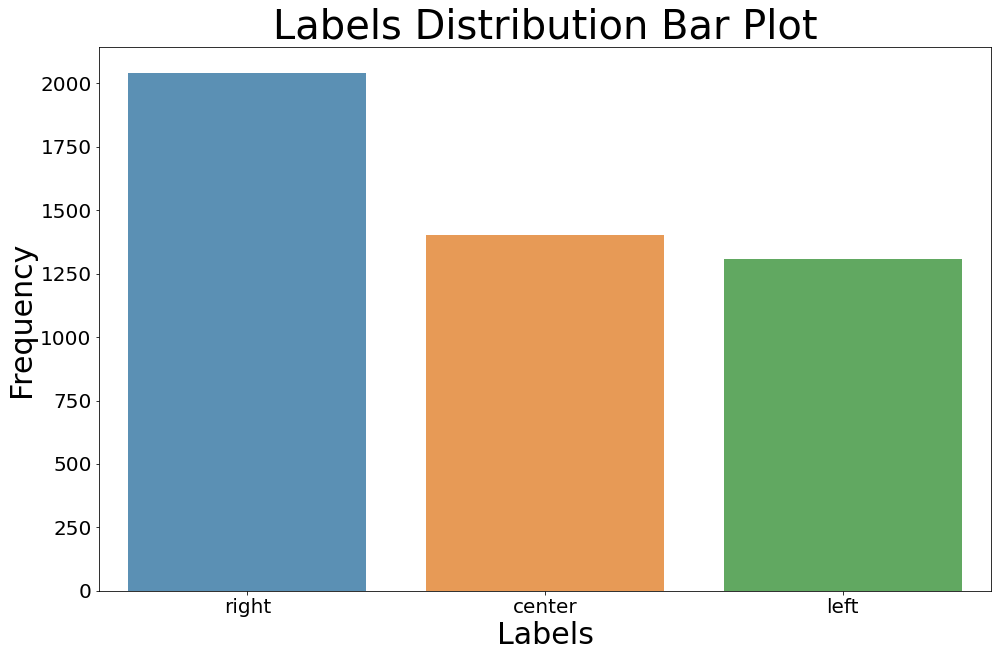

In [57]:
# plot the count of labels by class
plt.figure(figsize=(16,10))
sns.barplot(x_label.index, x_label.values, alpha=0.8)
plt.title("Labels Distribution Bar Plot", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Labels', fontsize=30)
plt.xticks(fontsize=20)
plt.savefig("../img/classDistBar.png")
plt.show()


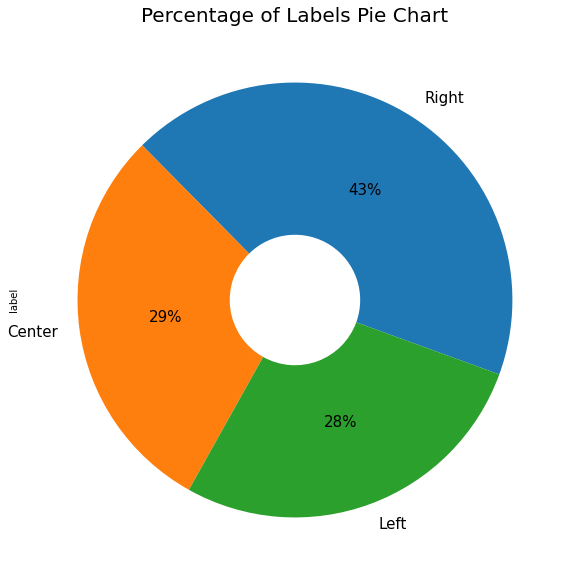

In [58]:
# pie chart of the percentages of labels by class
plt.figure(figsize=(16,10))
plt.title('Percentage of Labels Pie Chart', fontsize=20)
df.label.value_counts().plot(kind='pie', labels=['Right', 'Center', 'Left'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.savefig("../img/classDistPieChart.png")
plt.show()

In [59]:
# sentiment analysis
df['word_count'] = df.article.apply(lambda x: len(str(x).split()))
df['sentiment'] = df.article.apply(lambda x: TextBlob(x).sentiment.polarity)

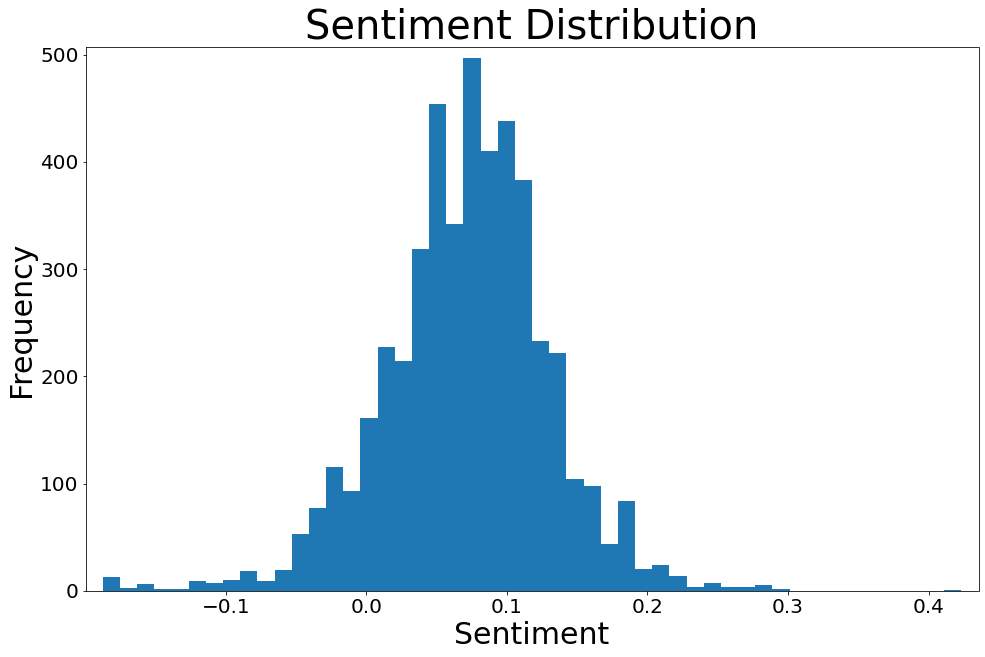

In [60]:
# plot of distribution of Sentiments
plt.figure(figsize=(16,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=40)
plt.savefig("../img/sentDistHist.png")
plt.show()


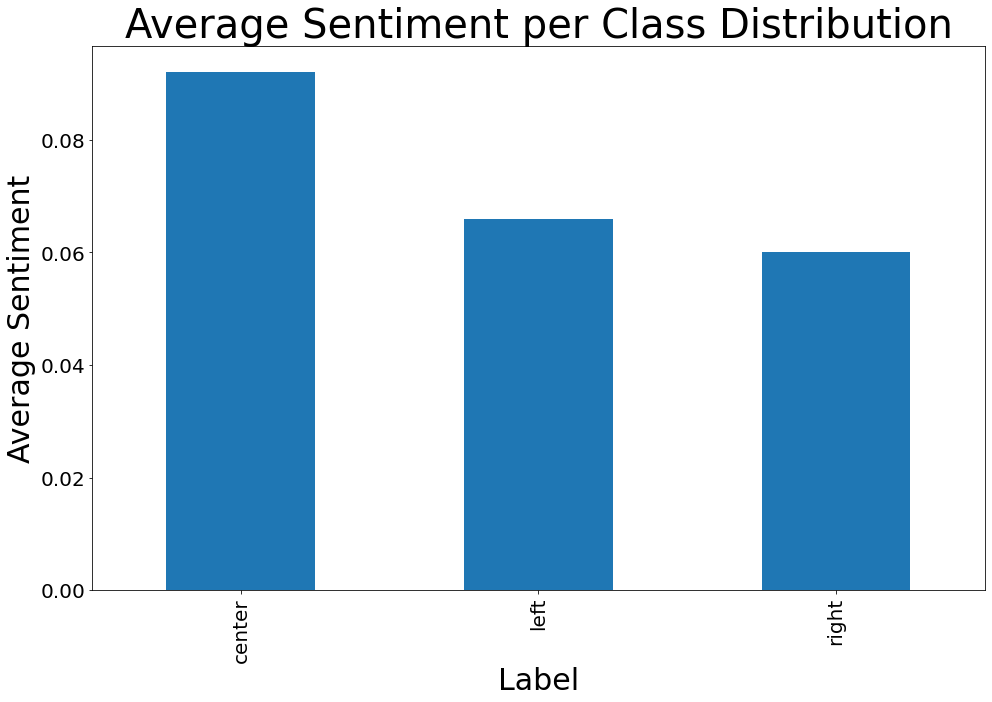

In [61]:
# plot average sentiment per Rating
polarity_avg = df.groupby('label')['sentiment'].mean().plot(kind='bar', figsize=(16,10))
plt.xlabel('Label', fontsize=30)
plt.ylabel('Average Sentiment', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Class Distribution', fontsize=40)
plt.savefig("../img/sentByClassAver.png")
plt.show()

In [62]:
# create the column with a length of each article
df['article_len'] = df.article.apply(lambda x:len(x))

/var/folders/c3/1vjm80gs2s1gq5k_8dh4rp1h0000gn/T/ipykernel_50072/2540265680.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


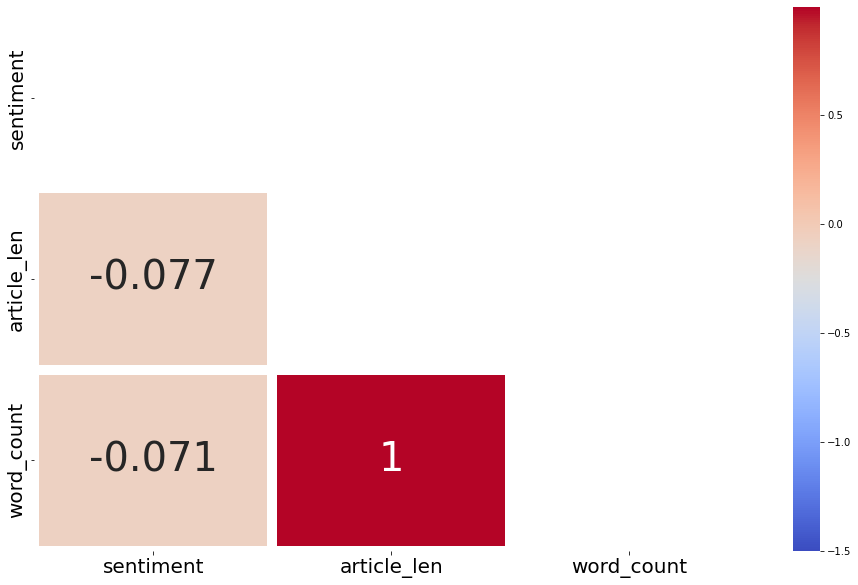

<Figure size 432x288 with 0 Axes>

In [63]:
# build a correlation heatmap for sentiment, article length, and word count 
correlation = df[['label','sentiment', 'article_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask);
plt.show()
plt.savefig("../img/heatmap.png")

## There is no correlation between beforementioned items

In [64]:
#free memory
del(df)

# In this section, I will build first models based on just counting technique (Tokenization)

In [65]:
# will start by "lemmatizing the articles" by creating lemmatizer
lemmatizer = WordNetLemmatizer()

In [66]:
df = pd.read_csv('../data/test_2.csv')

In [67]:
# create helping function for preparing each article for machine learning
def modify(text):
    text = re.sub(r'\d+', '', string=text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = " ".join([i for i in tokens if not i in stop_words])
    text  = word_tokenize(text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text])
    return text

In [68]:
# check if the helping function works
a = modify("been had done languages cities mice")
a

'done language city mouse'

In [69]:
# put 'cleaned' text into a column
df['cleaned'] = df.article.apply(modify)

In [70]:
# check if everything worked
df.head()

,article,label,cleaned
0,Mental health professionals are no substitute ...,right,Mental health professional substitute police c...
1,Merrick Garland's focus on school board meetin...,right,Merrick Garlands focus school board meeting vi...
2,The president has yet to clarify what victory ...,right,The president yet clarify victory pandemic loo...
3,"To hear President Joe Biden tell it, the Ameri...",right,To hear President Joe Biden tell American evac...
4,The mainstream media's honeymoon with Presiden...,right,The mainstream medias honeymoon President Joe ...


## Split the set into training and testing parts for machine learning.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned, df.label, test_size = 0.2, random_state = 42)

## Create a helper function that will print the assessement of the trained model 

In [72]:
def print_scores(clf, X_test, y_true):
    y_preds = clf.predict(X_test)
    print("*"*50)
    print("confusion matrix:\n", confusion_matrix(y_true, y_preds), "\n")
    print("*"*50)
    print("accuracy:\n", accuracy_score(y_true, y_preds), "\n")
    print("*"*50)
    print("precision:\n", precision_score(y_true, y_preds, average='weighted'), "\n")
    print("*"*50)
    print("recall:\n", recall_score(y_true, y_preds, average='weighted'), "\n")
    

## Put three models into the list

In [73]:
listModels = [MultinomialNB(), SGDClassifier(loss='hinge'), RandomForestClassifier()]
listModels

[MultinomialNB(), SGDClassifier(), RandomForestClassifier()]

## In the "for" loop create pipeline with countVectorizing for all three models, train each one of them and print the results

In [74]:
for clf in listModels:
    print(str(clf))
    pipe_clf = Pipeline([
        ('countVect', CountVectorizer()),
        ('clf', clf)
    ])
    pipe_clf.fit(X_train, y_train)
    print_scores(pipe_clf, X_test, y_test)
    

MultinomialNB()
**************************************************
confusion matrix:
 [[242  33   2]
 [ 12 248   9]
 [  0  13 392]] 

**************************************************
accuracy:
 0.9274447949526814 

**************************************************
precision:
 0.9303578968263958 

**************************************************
recall:
 0.9274447949526814 

SGDClassifier()
**************************************************
confusion matrix:
 [[272   3   2]
 [  5 257   7]
 [  1   5 399]] 

**************************************************
accuracy:
 0.9758149316508938 

**************************************************
precision:
 0.9757802360540695 

**************************************************
recall:
 0.9758149316508938 

RandomForestClassifier()
**************************************************
confusion matrix:
 [[276   1   0]
 [  1 266   2]
 [  0  15 390]] 

**************************************************
accuracy:
 0.9800210304942166 

**********

## Comment on the results: SGDClassifier with Support Vector Machines has the highest scores beating by a small margin Random Forest Classifier

## Add TFIDF to the pipeline, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. Retrain three models and print the results.

In [75]:
for clf in listModels:
    print(f"Current Model: {str(clf)}")
    pipeLine = Pipeline([
        ('countVect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (str(clf), clf)])
    pipeLine.fit(X_train, y_train)
    print(f"For {str(clf)} we achieve")
    print_scores(pipeLine, X_test, y_test)

Current Model: MultinomialNB()
For MultinomialNB() we achieve
**************************************************
confusion matrix:
 [[209  17  51]
 [  6 136 127]
 [  0   0 405]] 

**************************************************
accuracy:
 0.7886435331230284 

**************************************************
precision:
 0.8304178362333814 

**************************************************
recall:
 0.7886435331230284 

Current Model: SGDClassifier()
For SGDClassifier() we achieve
**************************************************
confusion matrix:
 [[273   4   0]
 [  1 266   2]
 [  1   6 398]] 

**************************************************
accuracy:
 0.9852786540483701 

**************************************************
precision:
 0.9855037620755629 

**************************************************
recall:
 0.9852786540483701 

Current Model: RandomForestClassifier()
For RandomForestClassifier() we achieve
**************************************************
confusion mat

## Comment on the results: Still, Support Vector Machines wins by scores and imporves by 0.4 percentage points with TFIDF added to the pipeline

# In this section, I will use word2vec embedding to see if it helps to improve the results 

In [76]:
# use gensim package to create functions that outputs iterators 
def read_corpus(texts, tokens_only = False):
    for i in range(len(texts)):
        tokens = gensim.utils.simple_preprocess(texts.iloc[i])
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [77]:
# apply the function to fit on the X_train
train_corpus = list(read_corpus(X_train))

In [78]:
# see the result
print(train_corpus[:1])

[TaggedDocument(words=['five', 'veteran', 'worked', 'advisory', 'council', 'sen', 'kyrsten', 'sinema', 'quit', 'post', 'thursday', 'scathing', 'letter', 'arizona', 'democrat', 'accusing', 'failing', 'major', 'holdout', 'among', 'democrats', 'working', 'advance', 'president', 'joe', 'biden', 'ambitious', 'domestic', 'agenda', 'refusing', 'support', 'package', 'would', 'cost', 'trillion', 'course', 'decade', 'paid', 'part', 'raising', 'tax', 'corporation', 'people', 'make', 'year', 'you', 'become', 'one', 'principal', 'obstacle', 'progress', 'answering', 'big', 'donor', 'rather', 'people', 'veteran', 'told', 'sinema', 'according', 'copy', 'letter', 'obtained', 'the', 'new', 'york', 'times', 'we', 'buy', 'representation', 'failure', 'stand', 'people', 'see', 'urgent', 'need', 'alarming', 'wrote', 'according', 'timesthe', 'resignation', 'latest', 'sign', 'democrats', 'growing', 'frustration', 'sinema', 'clear', 'exactly', 'want', 'colleague', 'include', 'include', 'legislation', 'win', 'vo

In [79]:
# apply the function to modify X_test
test_corpus = list(read_corpus(X_test, tokens_only=True))
print(len(test_corpus))
print(test_corpus[:1])# see the result

951
[['in', 'first', 'meeting', 'french', 'president', 'emmanuel', 'macron', 'since', 'spat', 'canceled', 'submarine', 'deal', 'september', 'president', 'biden', 'blamed', 'communication', 'snafui', 'impression', 'france', 'informed', 'long', 'french', 'deal', 'would', 'come', 'mr', 'biden', 'said', 'friday', 'honest', 'god', 'know', 'said', 'turning', 'macronwhen', 'australia', 'scuttled', 'submarine', 'deal', 'france', 'order', 'buy', 'submarine', 'us', 'british', 'technology', 'instead', 'macron', 'found', 'last', 'minute', 'mr', 'biden', 'australian', 'prime', 'minister', 'scott', 'morrison', 'british', 'prime', 'minister', 'boris', 'johnson', 'announced', 'deal', 'build', 'nuclearpowered', 'submarine', 'rather', 'diesel', 'submarine', 'australians', 'signed', 'contract', 'purchase', 'outraged', 'slight', 'france', 'canceled', 'social', 'event', 'us', 'recalled', 'ambassador', 'philippe', 'etienne', 'he', 'returned', 'us', 'day', 'later', 'mr', 'biden', 'macron', 'spoke', 'phone', 

In [80]:
# create the model to create Doc2Vec object
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [81]:
# build the vocabulary
model.build_vocab(train_corpus)

In [82]:
# test vocabulary on the word Trump
print(f"Word 'trump' appeared {model.wv.get_vecattr('trump', 'count')} times in the training corpus.")

Word 'trump' appeared 5200 times in the training corpus.


In [83]:
# train the mnodel
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [84]:
# import packages
from tqdm import tqdm
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [85]:
# apply trained Doc2Vec embedding to the train_corpus
X_for_tr = [model.infer_vector(x.words) for x in train_corpus]

In [86]:
# apply trained Doc2Vec embedding to the test_corpus
X_for_test = [model.infer_vector(x) for x in test_corpus]

## Create a new list of classifiers. Notice, that I don't use Naive Bayes since we have negative values in the feature matrices.

In [87]:
# example of negative values in X
X_for_test[0]

array([-0.9548627 , -3.9280171 ,  0.1060203 , -0.29701334, -3.4711084 ,
       -1.8122607 , -1.5524161 ,  1.2256222 , -1.9901435 , -0.68636656,
        1.3832206 ,  1.2205572 ,  0.5750259 , -0.04658929,  0.162449  ,
       -1.054098  ,  1.8723794 ,  0.48288548, -2.32327   , -0.60349643,
       -1.5090324 , -0.41382414,  0.30064   ,  1.0979284 ,  0.9905323 ,
        1.4496198 ,  0.9333509 , -0.59057295, -0.21528684, -1.0102665 ,
        1.6985266 ,  1.607429  ,  0.1007703 , -0.01434185,  0.23639016,
        0.34802213,  1.9044346 , -1.2622166 ,  0.15251493,  2.1797333 ,
        0.7677563 ,  1.5858402 , -0.80240035, -1.8936944 ,  2.2485516 ,
        1.7727556 , -1.0484371 , -2.5479023 ,  1.9224226 ,  0.5432856 ],
      dtype=float32)

In [88]:
# list of two classifiers
newListModels = [SGDClassifier(loss='hinge'), RandomForestClassifier()]
for clf in newListModels:
    print(f"Current Model: {str(clf)}")
    pipeLine = Pipeline([
        (str(clf), clf)])
    pipeLine.fit(X_for_tr, y_train)
    print(f"For {str(clf)} we achieve")
    print_scores(pipeLine, X_for_test, y_test)

Current Model: SGDClassifier()
For SGDClassifier() we achieve
**************************************************
confusion matrix:
 [[203  41  33]
 [ 23 245   1]
 [  0  15 390]] 

**************************************************
accuracy:
 0.8811777076761304 

**************************************************
precision:
 0.8835823425773163 

**************************************************
recall:
 0.8811777076761304 

Current Model: RandomForestClassifier()
For RandomForestClassifier() we achieve
**************************************************
confusion matrix:
 [[236  41   0]
 [ 11 258   0]
 [  0  15 390]] 

**************************************************
accuracy:
 0.9295478443743428 

**************************************************
precision:
 0.9365819614283306 

**************************************************
recall:
 0.9295478443743428 



## Comment on the results: Here we don't get scores that are higher then the previous scores. 

# Finaly, I will use deep learning to see if it gives better results

In [89]:
# Recreate the training/testing sets
[X, y] = [df.article, df.label]
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [90]:
# set the features for the embedding
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [91]:
# create a tokenizer object
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)

In [92]:
# fit the tokenizer on trainig set
tokenizer.fit_on_texts(X_train.values)

In [93]:
# create an index set
word_index = tokenizer.word_index

In [94]:
# number of unique tokens
print(f'Found {len(word_index)} unique tokens')

Found 44428 unique tokens


In [95]:
# convert training set to vectors
X_train_deep = tokenizer.texts_to_sequences(X_train.values)

In [96]:
# convert testing set to vectors
X_test_deep = tokenizer.texts_to_sequences(X_test.values)

In [97]:
# pad the vectors to the same size
X_train_deep = pad_sequences(X_train_deep, maxlen=MAX_SEQUENCE_LENGTH)
X_test_deep = pad_sequences(X_test_deep, maxlen=MAX_SEQUENCE_LENGTH)
print(f'SHape of data tensor: {X_train_deep.shape}')

SHape of data tensor: (3800, 250)


In [98]:
# convert categorical training targets into numerical with the help of LabelBinarier
lb = LabelBinarizer()
y_train_deep = lb.fit_transform(y_train.values)
y_train_deep[1]

array([0, 0, 1])

In [99]:
# convert categorical testing targets into numerical with the help of LabelBinarier
y_test_deep = lb.transform(y_test.values)
y_test_deep[1]

array([0, 0, 1])

In [100]:
# check if it worked
y_train_deep

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [101]:
# define a function that builds model for deep learning
def buildModel():
    optimizer = tf.keras.optimizers.Adam()
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_deep.shape[1]))
    model.add(SpatialDropout1D(0.2))
    #model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

In [102]:
# check if the shapes of X and y are the same
X_train_deep.shape, y_train.shape

((3800, 250), (3800,))

In [103]:
# train the model for 10 epochs
epochs = 10
batch_size = 48
model = buildModel()
history = model.fit(X_train_deep,
                    y_train_deep, 
                    epochs=epochs,
                    batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])

2021-11-15 17:34:45.387682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
64/64 [==============================] - 94s 1s/step - loss: 0.5851 - accuracy: 0.7503 - val_loss: 0.1294 - val_accuracy: 0.9605
Epoch 2/10
64/64 [==============================] - 94s 1s/step - loss: 0.0866 - accuracy: 0.9697 - val_loss: 0.0847 - val_accuracy: 0.9750
Epoch 3/10
64/64 [==============================] - 98s 2s/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.1333 - val_accuracy: 0.9579
Epoch 4/10
64/64 [==============================] - 100s 2s/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.1128 - val_accuracy: 0.9750
Epoch 5/10
64/64 [==============================] - 99s 2s/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.1085 - val_accuracy: 0.9632


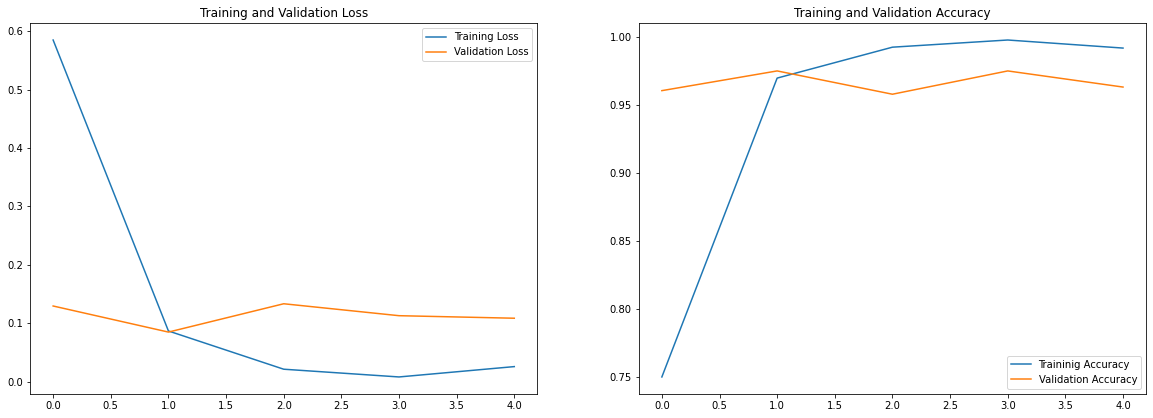

In [104]:
# plot the loss and accuracy graphs 
plt.figure(figsize=(20,15))
plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Traininig Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show();

In [105]:
# check the usual metrics to compare models
y_preds = model.predict(X_test_deep)
y_preds = np.argmax(model.predict(X_test_deep), axis=1)
y_preds = [lb.classes_[i] for i in y_preds]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_preds))
print("Accuracy Score:\n", accuracy_score(y_test, y_preds))
print("Precision Score:\n", precision_score(y_test, y_preds,average=None).mean())
print("Recall Score: \n", recall_score(y_test, y_preds,average=None).mean())

Confusion Matrix:
 [[262  13   2]
 [  7 243  19]
 [  1   9 395]]
Accuracy Score:
 0.9463722397476341
Precision Score:
 0.9456235777383576
Recall Score: 
 0.9415009141112117


# We can see that the highest score was achieved with the SGDClassifier with the SVM loss model when we used TFIDF. The  Let's retrain this model on the whole dataset.

In [267]:
X, y  = df.article, df.label

In [268]:
X = [modify(x) for x in X]
clf = SGDClassifier(loss='hinge')

In [269]:
pipe_clf = Pipeline([
    ('countVect', CountVectorizer(stop_words=stop, lowercase=True)),
    ('tfidf', TfidfTransformer()),
    (str(clf), clf)
])

In [270]:
pipe_clf.fit(X, y)

Pipeline(steps=[('countVect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidf', TfidfTransformer()),
                ('SGDClassifier()', SGDClassifier())])

In [271]:
print_scores(pipe_clf, X, y)

**************************************************
confusion matrix:
 [[1400    1    0]
 [   0 1309    0]
 [   0    0 2041]] 

**************************************************
accuracy:
 0.9997895179962113 

**************************************************
precision:
 0.9997896786694966 

**************************************************
recall:
 0.9997895179962113 



# Let's take a look at the 10 largest coefficients (by absolute value) in each class of the SVM model and corresonding features.

In [295]:
coeffDict = {}
vocab = list(pipe_clf["countVect"].vocabulary_.keys())
for j in [0,1,2]:
    print("*"*20, "\nClass = ", pipe_clf.classes_[j],"\n" ,"*"*20)
    coeff = list(pipe_clf["SGDClassifier()"].coef_[j])
    newCoeff = coeff.copy()
    newCoeff = [(abs(x), vocab[coeff.index(x)]) for x in newCoeff]
    print(newCoeff[:3])
    coeffDict[j] = newCoeff
    #newCoeff.sort(reverse=True)
    """
    for i in newCoeff[:10]:
        index_of_largest = coeff.index(i)
        print("coeff = ", i, "|| Corresponding word =", vocab[index_of_largest])
    """

******************** 
Class =  center 
 ********************
[(0.04200925412765385, 'mental'), (0.044044851641487824, 'health'), (0.0, 'professional')]
******************** 
Class =  left 
 ********************
[(0.013727321806747895, 'mental'), (0.014143063702946632, 'health'), (0.0554312146328703, 'professional')]
******************** 
Class =  right 
 ********************
[(0.03243588974454318, 'mental'), (0.0, 'health'), (0.05505069566787947, 'professional')]


/var/folders/c3/1vjm80gs2s1gq5k_8dh4rp1h0000gn/T/ipykernel_50072/2430482061.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(list(x), rotation =30)


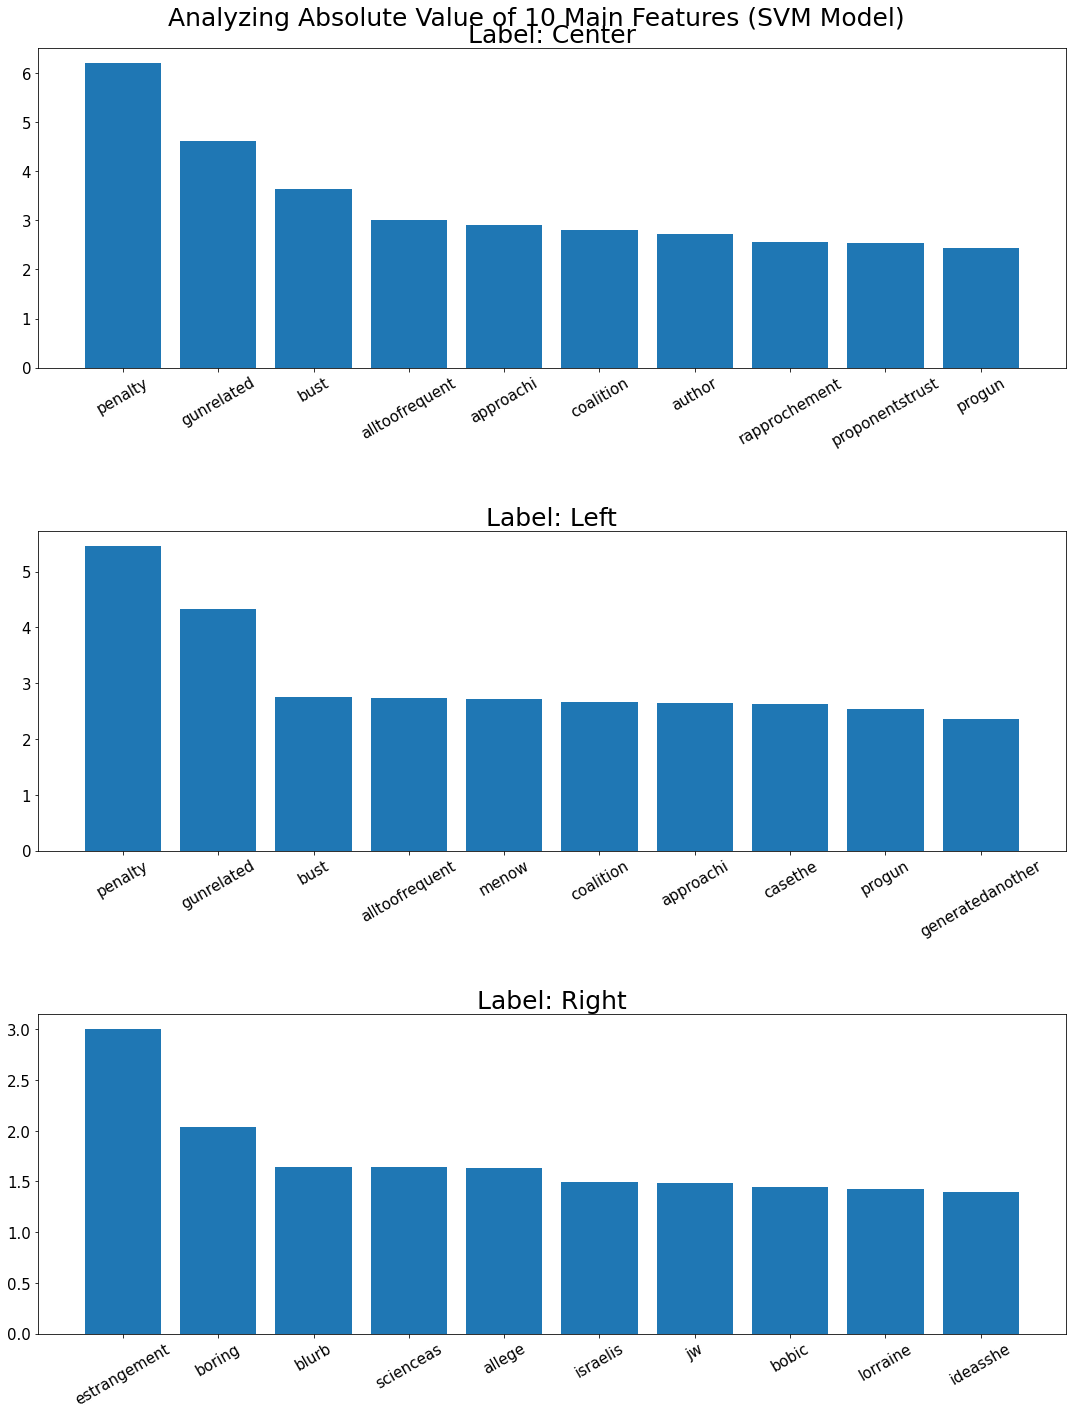

In [311]:
fig, axs = plt.subplots(3, figsize=(15,20))
fig.suptitle('Analyzing Absolute Value of 10 Main Features (SVM Model)', fontsize=25)
for i, class_ in enumerate(pipe_clf.classes_):
    coeffDict[i].sort(reverse=True)
    coefPlot = coeffDict[i][:10]
    y, x = zip(*coefPlot)
    axs[i].bar(x,y)
    axs[i].set_title("Label: " + class_.capitalize(), fontsize=25)
    axs[i].tick_params(labelsize=15)
    axs[i].set_xticklabels(list(x), rotation =30)
    fig.tight_layout(h_pad=5, w_pad=5)
    

# Save the Model 

In [113]:
import joblib

In [114]:
joblib.dump(pipe_clf, open("../data/model.pkl", 'wb'))

# Conclusion
 I used the Support Vector Machines model for the final training. We have perfect scores in our final training which is a bit surprising. The trained model might not scale well on the new data since it might be overfitted.

# Business Decision
I suggest to use Support Vector Machines model for the prediction of the political inclanation of the article. It can help internet users who are not sure about the flavor of the political news to verify what kind of an article they are reading. I have to add, that collecting more data would improve the performance of the model.


# Ways to improve the model.
* Collecting more data from different websites would make the model more robust and scalable.
* Building more advanced deep learning model model with stacked LSTM layers.
* Use XGBosst classifier.